In [36]:
from numpy.random.mtrand import choice
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame

from data_analysis.util import set_ax_pixel_size
from mafia.voting_strategies import *

plt.style.use('ggplot')

typical_tactics = [
    ChancesOfVotingForRedIfRed(0.01),
    ChancesOfVotingForRedIfBlack(0.50),
    ChancesOfVotingForBlackIfRed(0.99),
    ChancesOfVotingForBlackIfBlack(0.50),
    AlwaysVoteForBlackCheckedBySheriff(),
    ChancesOfVotingForRedThatIsCheckedBySheriff(0),
    MafiaKillsUncoveredRed(1),
    MafiaKillsUncoveredSheriff(1),
    RedMustPutOnVoteUncoveredBlack(1),
    RedMustAvoidToPutOnVoteUncoveredRed(0),
]
skilled_tactics = [
    ChancesOfVotingForRedIfRed(0.99),
    ChancesOfVotingForRedIfBlack(0.50),
    ChancesOfVotingForBlackIfRed(0.01),
    ChancesOfVotingForBlackIfBlack(0.50),
    AlwaysVoteForBlackCheckedBySheriff(),
    ChancesOfVotingForRedThatIsCheckedBySheriff(0),
    MafiaKillsUncoveredRed(1),
    MafiaKillsUncoveredSheriff(1),
    RedMustPutOnVoteUncoveredBlack(1),
    RedMustAvoidToPutOnVoteUncoveredRed(0),
]

gamer_ids = [f'Gamer #{g}' for g in range(30)]


In [37]:
columns = ['g_time', 'g_who_wins', 'g_total_rounds', 'g_when_sheriff_killed', 'p_#', 'gamer_id', 'p_role', 'votes_for_reds', 'votes_for_black']
games_count = 100

df = DataFrame(columns=columns)
for g in range(games_count):
    game = Game()
    chosen_ids = choice(gamer_ids, replace=False, size=10).tolist()

    players_strategies = [[g_id, typical_tactics] for g_id in chosen_ids]
    is_5_in_game = chosen_ids.index('Gamer #5') if 'Gamer #5' in chosen_ids else None
    if is_5_in_game:
        players_strategies[is_5_in_game][1] = skilled_tactics

    is_5_in_game = chosen_ids.index('Gamer #6') if 'Gamer #6' in chosen_ids else None
    if is_5_in_game:
        players_strategies[is_5_in_game][1] = skilled_tactics

    is_5_in_game = chosen_ids.index('Gamer #7') if 'Gamer #7' in chosen_ids else None
    if is_5_in_game:
        players_strategies[is_5_in_game][1] = skilled_tactics

    is_5_in_game = chosen_ids.index('Gamer #8') if 'Gamer #8' in chosen_ids else None
    if is_5_in_game:
        players_strategies[is_5_in_game][1] = skilled_tactics

    is_5_in_game = chosen_ids.index('Gamer #9') if 'Gamer #9' in chosen_ids else None
    if is_5_in_game:
        players_strategies[is_5_in_game][1] = skilled_tactics

    game.init_game(players_strategies)
    while True:
        game.commit_night_events()
        if game.the_game_is_over:
            break
        game.commit_day_events()
        if game.the_game_is_over:
            break

    stats = []
    p: Player

    for p in game.players:
        num_of_votes_for_reds = len([x for x in game.game_statistics['who_vote_who'] if p == x[0] and x[1].is_red()])
        num_of_votes_for_black = len([x for x in game.game_statistics['who_vote_who'] if p == x[0] and x[1].is_maf()])
        stats.append([game.game_time, game.who_wins, game.day_number, game.game_statistics['when_sheriff_killed'], p.number, p.g_id, p.role, num_of_votes_for_reds, num_of_votes_for_black])

    df = pd.concat([df, DataFrame(columns=columns, data=stats)], ignore_index=True)

df['p_is_winner'] = ((df['g_who_wins'] == 'reds') & ((df['p_role'] == 'r') | (df['p_role'] == 's'))) | ( (df['g_who_wins'] == 'maf') & (df['p_role'] == 'm') )
df['p_is_winner'] = df['p_is_winner'].astype('int8')


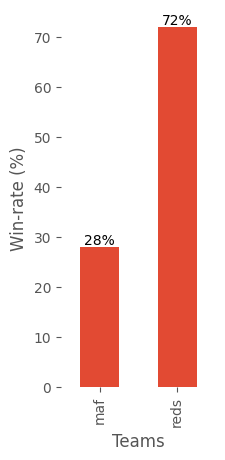

In [38]:
who_wins = df.groupby(['g_time', 'g_who_wins']).agg(wins_count=('g_who_wins', 'count')).reset_index()
who_wins = who_wins.groupby('g_who_wins').agg(wins_by_team=('g_who_wins', 'count')) / len(who_wins) * 100
ax = who_wins.plot(kind='bar', legend=False)
ax.set_frame_on(False)
ax.set_xlabel('Teams')
ax.set_ylabel('Win-rate (%)')
ax.bar_label(ax.containers[0], fmt='%.0f%%')
set_ax_pixel_size(ax, width=200)


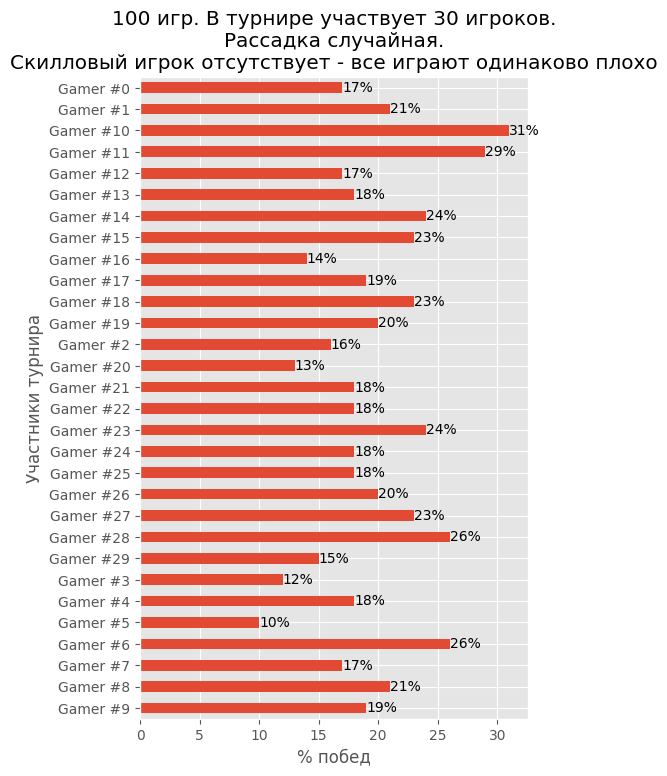

In [39]:
win_rate = df.groupby('gamer_id').agg(win_count=('p_is_winner', 'sum')) / games_count * 100
# win_rate.index = ['Player 01, skill: 50%', 'Player 02, skill: 50%', 'Player 03, skill: 50%', 'Player 04, skill: 50%', 'Player 05, skill: 99%', 'Player 06, skill: 50%', 'Player 07, skill: 50%', 'Player 08, skill: 50%', 'Player 09, skill: 50%', 'Player 10, skill: 50%', ]
ax = win_rate.sort_index(ascending=False).plot(kind='barh', legend=False)
set_ax_pixel_size(ax, 500, 850)
ax.bar_label(ax.containers[0], fmt='%.0f%%')
ax.set_ylabel('Участники турнира')
ax.set_xlabel('% побед')
ax.set_title(f'{games_count} игр. В турнире участвует 30 игроков.\nРассадка случайная.\nСкилловый игрок отсутствует - все играют одинаково плохо')
plt.show()

In [40]:
win_rate_by_sheriff_longevity = df.groupby(['g_time', 'g_when_sheriff_killed', 'g_who_wins']).agg(wins_count=('g_who_wins', 'count')).reset_index()

win_rate_by_sheriff_longevity_g = win_rate_by_sheriff_longevity.groupby(['g_who_wins', 'g_when_sheriff_killed']).agg(wins_by_team=('g_who_wins', 'count')) / len(win_rate_by_sheriff_longevity) * 100
win_rate_by_sheriff_longevity_g


wins_by_team
g_who_wins g_when_sheriff_killed              
maf        0                               4.0
           1                               7.0
           2                              13.0
           10                              4.0
reds       0                               7.0
           1                              11.0
           2                              48.0
           10                              6.0